# Compare the following for truncated SVD:

1. Randomized Block Power Method. This algorithm was introduced in [Finding structure with randomness: Stochastic algorithms for constructing approximate matrix decompositions - Halko, et al., 2009]([http://arxiv.org/abs/arXiv:0909.4061]) and used in:
    1. [FB PCA](https://github.com/facebook/fbpca)
    2. [http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html](scikit-learn's Truncated SVD)
    3. [Breeze's svdr](https://github.com/scalanlp/breeze/blob/master/math/src/main/scala/breeze/linalg/functions/svdr.scala)
2. Randomized Krylov block method - This was introduced by [Musco 2015](http://papers.nips.cc/paper/5735-randomized-block-krylov-methods-for-stronger-and-faster-approximate-singular-value-decomposition)
3. **(TODO)** Lazy SVD - from [LazySVD: Even Faster SVD Decomposition Yet Without Agonizing Pain](http://papers.nips.cc/paper/6507-lazysvd-even-faster-svd-decomposition-yet-without-agonizing-pain)
4. **(TODO)** Streaming PCA from Gensim author - [Fast and Faster: A Comparison of Two Streamed Matrix Decomposition Algorithms](https://arxiv.org/abs/1102.5597)

In [7]:
import numpy as np
import numpy.linalg as nla
import fbpca
import gensim
import scipy.linalg as sla
import sklearn.decomposition.pca as skpca
import matplotlib.pyplot as plt
from sklearn.decomposition import randomized_svd as sk_rand_svd
import time

In [3]:
import os

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## helper assert methods

In [83]:
from numpy.testing import assert_almost_equal

In [107]:
def svd_err_spectral_norm(orig, svdapprox_func, **args):
    U, s, Vh = svdapprox_func(orig, **args)
    return nla.norm((U * s).dot(Vh) - orig, 2)

## hyperparams

In [239]:
num_components = 20
n_iter = 5
rank = 20
num_rows = 500
num_cols = 100

## sample data generator

We generate a random matrix of a particular (approximate/rough) rank by doing **"SVD backwards"**. That is, we generate the $U$, $V$, and $E$ of SVD's $A = UEV^T$.

1. We generate orthogonal matrices $U$ and $V$ via the QR decomposition on a random matrix. (QR gives as an orthogonal $Q$ and a right-triangular $R$)
2. Generate singular values in $E$ according to an exponentially decreasing formula $e^{-(i/rank)^2}$, where $\textbf{i}$ is the singular value index, and $\textbf{rank}$ is the input parameter.

In [240]:
def gen_tail_noise(n, normalizer):
    return np.exp(-0.1 * np.arange(n) / normalizer)

def gen_exp_decrease(n, normalizer):
    return np.exp(-1.0 * np.power(np.arange(n) / normalizer, 2))

def gen_low_rank_matrix(m, n, rank=5, long_tail_factor=0.0):
    smaller_dim = min(m, n)
    U, _ = sla.qr(np.random.randn(m, smaller_dim), mode="economic")
    V, _ = sla.qr(np.random.randn(n, smaller_dim), mode="economic")
    exponential_decrease = gen_exp_decrease(smaller_dim, rank)#np.exp(-1.0 * np.power(np.arange(1, n) / rank, 2))
    tail_noise = gen_tail_noise(smaller_dim, rank)
    s = np.array((1.0 - long_tail_factor) * exponential_decrease + \
                 (long_tail_factor) * tail_noise)
    return np.dot(U * s, V.T)

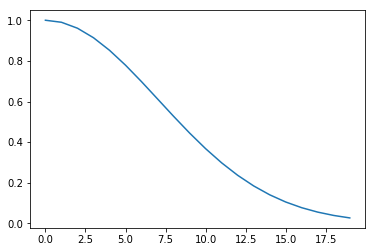

In [241]:
plt.plot(gen_exp_decrease(20,10))

In [242]:
A = gen_low_rank_matrix(m=num_rows, n=num_cols, rank=rank, long_tail_factor=0.5)

## Test FBPCA and SKlearn Truncated SVD implementations

In [243]:
fbpca_err = svd_err_spectral_norm(A, fbpca.pca, k=num_components, n_iter=n_iter)
print(fbpca_err)

0.65756518295


In [244]:
sk_err = svd_err_spectral_norm(A, sk_rand_svd, n_components=num_components, n_iter=n_iter)
print(sk_err)

0.636360478052


In [245]:
sk_QR_err = svd_err_spectral_norm(A, sk_rand_svd, power_iteration_normalizer="QR", n_components=num_components, n_iter=n_iter)
print(sk_QR_err)

0.636360478052


## krylov subspace implementation

In [347]:
from randomized_block_krylov import randomized_krylov_svd

ImportError: cannot import name 'randomized_block_krylov_svd'

In [346]:
krylov_err = svd_err_spectral_norm(A, randomized_krylov_svd, n_components=num_components, n_iter=n_iter)
print(krylov_err)

0.636358429604


# Halko (block power iter)

In [312]:
from randomized_block_power_iteration import rand_block_power_iter

In [313]:
streaming_err = svd_err_spectral_norm(A, rand_block_power_iter, n_components=num_components, n_iter=n_iter)
print(streaming_err)

pre-power Q shape= (500, 30)
post-power Q shape= (500, 30)
0.636358607764
